# Exposure Grouping
We need an exposure grouping algorithm that works visually. Using timestamps does a poor job, as there are a number of misgroupings that pop up.

## Mutual Information
Here, we use mutual information as an exposure-invariant similarity metric.

In [31]:
from numpy import histogram2d
from sklearn.metrics import mutual_info_score

def mutual_information (input, target):
    H, _, _ = histogram2d(input.ravel(), target.ravel(), bins=255)
    mi = mutual_info_score(None, None, contingency=H)
    return mi

Let us test it with some images:

In [125]:
%matplotlib inline

from cv2 import imread, resize, INTER_AREA
from matplotlib import pyplot as plt

# Load images
images = [imread(f"../test/media/group/{i+1}.jpg", 0) for i in range(0, 32)]
images = [resize(image, (512, 512), interpolation=INTER_AREA) for image in images]

We plot the images:

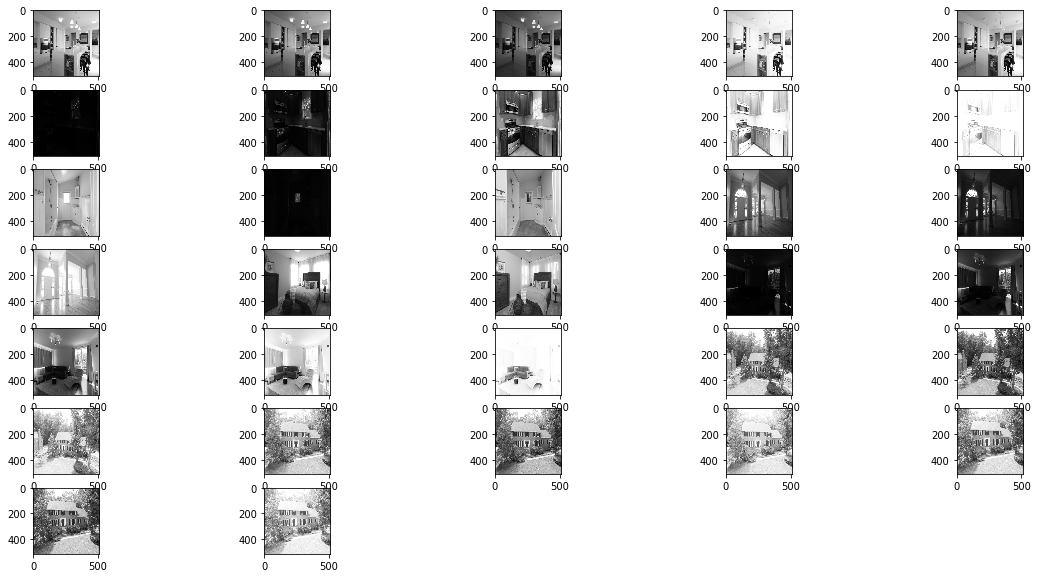

In [95]:
# Display
plt.figure(figsize=(20, 10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image, cmap="gray", vmin=0, vmax=255)

Then compute the mutual info

In [18]:
for i in range(len(images) - 1):
    print(f"{i} -> {i+1}:", mutual_information(images[i], images[i+1]))

0 -> 1: 3.9825269160147165
1 -> 2: 3.680435006215342
2 -> 3: 2.257418206815694
3 -> 4: 3.7189575244591526
4 -> 5: 0.14276721215405885
5 -> 6: 1.6224676368926205
6 -> 7: 3.0792716653868797
7 -> 8: 2.47764226656554
8 -> 9: 1.3103518024779992
9 -> 10: 0.11844892893817754
10 -> 11: 1.5823262984285846
11 -> 12: 0.4208660307215676


## Equalized Mutual Information
We build upon mutual information by improving on exposure invariance. We do so by first histogram-matching image pairs before proceeding with the MI computation.

In [24]:
from numpy import float64, interp, unique

def histogram_match (input, target):
    # Source: https://stackoverflow.com/questions/32655686/histogram-matching-of-two-images-in-python-2-x
    s_values, bin_idx, s_counts = unique(input.ravel(), return_inverse=True, return_counts=True)
    t_values, t_counts = unique(target.ravel(), return_counts=True)
    s_quantiles = s_counts.cumsum().astype(float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = t_counts.cumsum().astype(float64)
    t_quantiles /= t_quantiles[-1]
    interp_t_values = interp(s_quantiles, t_quantiles, t_values)
    result = interp_t_values[bin_idx].reshape(input.shape)
    return result

Now, we visualize the matching:

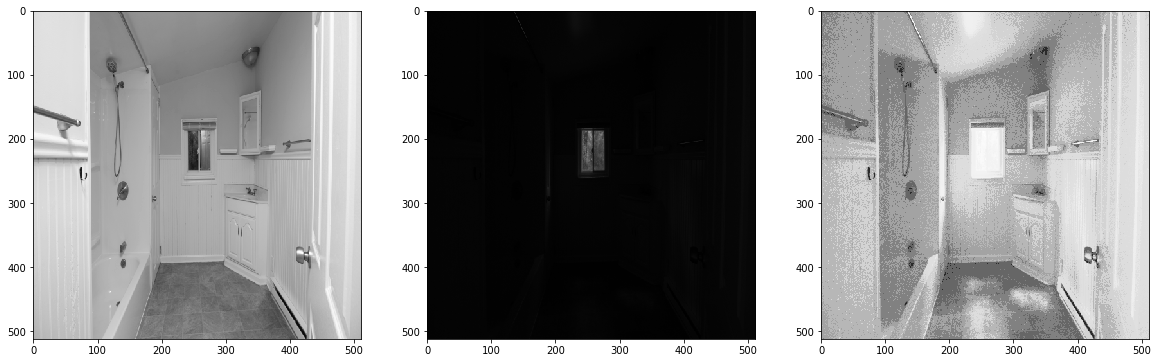

In [28]:
input, target = images[11], images[12]
matched = histogram_match(input, target)

plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(target, cmap="gray", vmin=0, vmax=255)
plt.subplot(1, 3, 2)
plt.imshow(input, cmap="gray", vmin=0, vmax=255)
plt.subplot(1, 3, 3)
plt.imshow(matched, cmap="gray", vmin=0, vmax=255)

Now, we compare the MI of the base pair and the matched pair:

In [29]:
print(f"Base pair:", mutual_information(target, input))
print(f"Matched pair:", mutual_information(target, matched))

Base pair: 0.4208660307215677
Matched pair: 0.40650657107091476


Interestingly, histogram matching is entirely invariant to exposure changes.

## Cross Correlation
The next measure is on cross-correlation.

In [35]:
from numpy import cov

def cross_correlation (input, target):
    covariance = cov(input.ravel(), target.ravel())[0,1]
    corr = covariance / input.std() / target.std()
    return corr

Now, we check the result:

In [36]:
for i in range(len(images) - 1):
    print(f"{i} -> {i+1}:", cross_correlation(images[i], images[i+1]))

0 -> 1: 0.985019863150165
1 -> 2: 0.983171568527542
2 -> 3: 0.7944770247125826
3 -> 4: 0.9601259176635742
4 -> 5: 0.12427344413549608
5 -> 6: 0.8605604434798183
6 -> 7: 0.8464497622982633
7 -> 8: 0.8218187016943425
8 -> 9: 0.880183343957082
9 -> 10: 0.16278094933406775
10 -> 11: 0.4993146229989855
11 -> 12: -0.0402349010781205


Now, we check for exposure invariance:

In [38]:
print(f"Base pair:", cross_correlation(target, input))
print(f"Matched pair:", cross_correlation(target, matched))

Base pair: -0.0402349010781205
Matched pair: 0.4667874596890525


Base pair: 0.4993146229989855
Matched pair: 0.9706367743903173


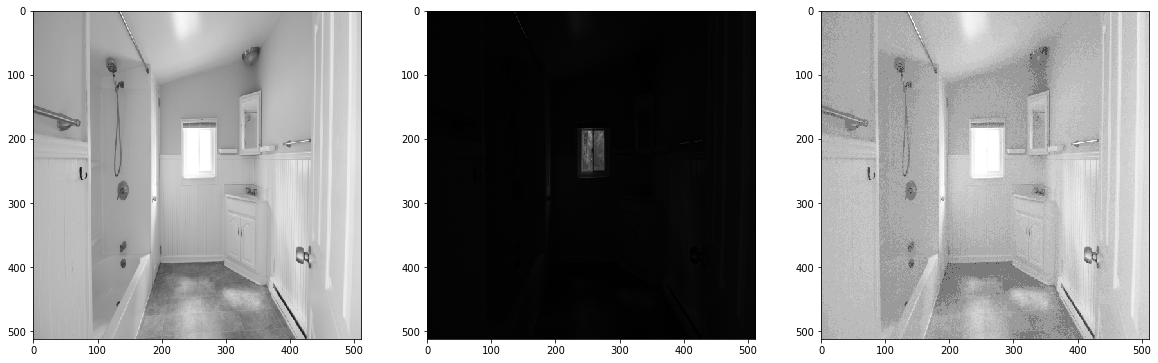

In [45]:
input, target = images[11], images[10]
matched = histogram_match(input, target)
print(f"Base pair:", cross_correlation(target, input))
print(f"Matched pair:", cross_correlation(target, matched))

plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(target, cmap="gray", vmin=0, vmax=255)
plt.subplot(1, 3, 2)
plt.imshow(input, cmap="gray", vmin=0, vmax=255)
plt.subplot(1, 3, 3)
plt.imshow(matched, cmap="gray", vmin=0, vmax=255)

## Equalized Cross Correlation
In the above tests, CC is sensitive to exposure. As such, we can perform a smarter check by matching the exposure of one image to that of the other. Since this is not symmetric, we must properly choose the input and target for the matching. A proposed metric is $\sigma$.

In [46]:
for i, image in enumerate(images):
    print(f"Image {i}:", image.std())

Image 0: 58.36885622959307
Image 1: 54.40189322189025
Image 2: 47.74386113406334
Image 3: 55.88084463776669
Image 4: 58.59905790139797
Image 5: 7.566685595900666
Image 6: 28.745958196894595
Image 7: 61.56011546842377
Image 8: 47.34624037029671
Image 9: 19.494940314816887
Image 10: 28.976115753327488
Image 11: 7.084557539094469
Image 12: 40.352309810212624


As expected, $\sigma$ gives us a good approximation of detail in the image. As such, we match the image with the lower $\sigma$ to that of the higher $\sigma$:

In [51]:
def equalized_cross_correlation (image_a, image_b):
    std_a, std_b = image_a.std(), image_b.std()
    input, target = (image_a, image_b) if std_a < std_b else (image_b, image_a)
    matched = histogram_match(input, target)
    return cross_correlation(matched, target)

Now, we check:

In [73]:
for i in range(len(images) - 1):
    print(f"{i+1} -> {i+2}:", equalized_cross_correlation(images[i], images[i+1]))

1 -> 2: 0.9992310248252371
2 -> 3: 0.9983636375931009
3 -> 4: 0.9861141904682271
4 -> 5: 0.9987690496081532
5 -> 6: 0.060397102645142295
6 -> 7: 0.992131656991335
7 -> 8: 0.9984224459378062
8 -> 9: 0.9684194468450958
9 -> 10: 0.9769069306013908
10 -> 11: 0.18542601042358398
11 -> 12: 0.9706367743903171
12 -> 13: 0.4667874596890525
13 -> 14: -0.1390331302301633
14 -> 15: 0.9993986615453401
15 -> 16: 0.9988381504826666
16 -> 17: 0.03442400287408541
17 -> 18:0.8310483325696145
18 -> 19: 0.20266811838086735
19 -> 20: 0.9976009184708756
20 -> 21: 0.9987426586047384
21 -> 22: 0.9984327684923983
22 -> 23: 0.9956918272316588
23 -> 24: -0.19107097742119777
24 -> 25: 0.9896202300353689
25 -> 26: 0.9921945770440167
26 -> 27: 0.24921195401661694
27 -> 28: 0.9711221298068469
28 -> 29: 0.9798584835133108
29 -> 30: 0.6881544782273812
30 -> 31: 0.999121341991043
31 -> 32: 0.9984774571659891


This works quite well. As such, we can write the grouping algorithm as:

In [76]:
def group_exposures_ecc (images, min_correlation=0.25):
    groups = []
    current_group = [images[0]]
    for i in range(1, len(images)):
        correlation = equalized_cross_correlation(images[i-1], images[i])
        if (correlation < min_correlation):
            groups.append(current_group)
            current_group = []
        current_group.append(images[i])
    groups.append(current_group)
    return groups

Now, let's test it.

In [78]:
groups = group_exposures_ecc(images)
[len(group) for group in groups]

[5, 5, 3, 3, 2, 5, 3, 6]

## Equalized Laplacian of Gaussian

In [120]:
from cv2 import GaussianBlur, Laplacian, CV_64F
from numpy import absolute

def equalized_laplacian_of_gaussian (image_a, image_b):
    # Match for exposure invariance
    std_a, std_b = image_a.std(), image_b.std()
    input, target = (image_a, image_b) if std_a < std_b else (image_b, image_a)
    matched = histogram_match(input, target)
    # Compute LoG
    matched_LoG = Laplacian(GaussianBlur(matched, (3, 3), 0), CV_64F)
    target_LoG = Laplacian(GaussianBlur(target, (3, 3), 0), CV_64F)
    # Compute difference
    delta = absolute(matched_LoG - target_LoG).sum()
    return delta / matched_LoG.size

Test:

In [121]:
for i in range(len(images) - 1):
    print(f"{i+1} -> {i+2}:", equalized_laplacian_of_gaussian(images[i], images[i+1]))

1 -> 2: 1.2734236995915222
2 -> 3: 1.5365672338760845
3 -> 4: 5.171528686079196
4 -> 5: 1.2254539074509039
5 -> 6: 1.389755308960852
6 -> 7: 8.35677552367509
7 -> 8: 1.6900752946245166
8 -> 9: 1.777514414166513
9 -> 10: 4.481120832528475
10 -> 11: 1.4609962445753866
11 -> 12: 1.7900688641632663
12 -> 13: 4.387562767777832
13 -> 14: 1.1785687754365797
14 -> 15: 1.5884410472904174
15 -> 16: 6.856800617920854
16 -> 17: 1.2501616759030296
17 -> 18: 1.5433887110636737
18 -> 19: 8.109085614886709
19 -> 20: 1.305466672265909
20 -> 21: 1.4610471038067712
21 -> 22: 5.391897372993733
22 -> 23: 1.4222106631531244
23 -> 24: 1.6075180623254146
24 -> 25: 6.558638137146049
25 -> 26: 1.2403897190909696
26 -> 27: 3.27167185373745
27 -> 28: 5.63060760040433
28 -> 29: 1.3574667201788948
29 -> 30: 1.597304837359277
30 -> 31: 4.827199305126246
31 -> 32: 1.2802276345577877
32 -> 33: 1.4265663501020869
33 -> 34: 6.60367287328241
34 -> 35: 1.342222588055305
35 -> 36: 1.6399462187809455
36 -> 37: 7.30834392904

In [123]:
def group_exposures_elog (images, max_delta=3.5):
    groups = []
    current_group = [images[0]]
    for i in range(1, len(images)):
        delta = equalized_laplacian_of_gaussian(images[i-1], images[i])
        if (delta > max_delta):
            groups.append(current_group)
            current_group = []
        current_group.append(images[i])
    groups.append(current_group)
    return groups

In [126]:
# Group
groups = group_exposures_elog(images)
[len(group) for group in groups]

[5, 3, 2, 2, 1, 3, 1, 1, 5, 1, 2, 1, 1, 1, 3]

## Tests

In [111]:
# Load images
images = [imread(f"/Users/yusuf/Desktop/16 Troon Way/brackets/{i+1}.jpg", 0) for i in range(0, 108)]
images = [resize(image, (512, 512), interpolation=INTER_AREA) for image in images]

In [ ]:
# Compute ECC
for i in range(len(images) - 1):
    print(f"{i+1} -> {i+2}:", equalized_cross_correlation(images[i], images[i+1]))

# Group
groups = group_exposures(images)
[len(group) for group in groups]

## Matching


In [137]:
from cv2 import imwrite
from numpy import uint8

a = imread(f"../test/media/group/12.jpg", 1)
b = imread(f"../test/media/group/13.jpg", 1)

c = histogram_match(a, b).astype(uint8)
c = GaussianBlur(c, (5, 5), 0)
imwrite("match.jpg", c)

True